# Kaggle's Santander Value Prediction Challenge
Santander has provided an anonymized data to predict value of transaction for each potential customer.
After cleaning the dataset, I have used LightGBM to predict target value from the given features.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load training data and testing data
train=pd.read_csv("train.csv")
train_df=pd.DataFrame(train)

test=pd.read_csv("test.csv")
test_df=pd.DataFrame(test)

In [3]:
train_df.describe()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.260000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+07,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


In [4]:
# Locate columns with only one unique value
columns=train_df.columns
i=0
columns_to_remove=[]
for c in columns:
    if train_df[c].nunique()==1:
        columns_to_remove.append(c)
        i=i+1
print(i)

256


In [5]:
# Drop unwanted columns
train_df.drop(columns_to_remove,inplace=True,axis=1)
test_df.drop(columns_to_remove,inplace=True,axis=1)
test_df.drop(['ID'],inplace=True,axis=1)

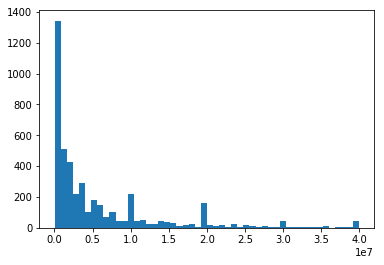

In [6]:
# Plot target values
plt.hist(((train_df['target'].values)),bins=50)
plt.show()

Target values are skewed, hence applying log transormation can be a good option

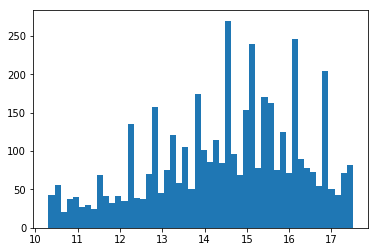

In [7]:
# Plot tranformed target values
plt.hist((np.log(train_df['target'].values)),bins=50)
plt.show()

# Training LightGBM

In [10]:
import lightgbm as lgb
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split

In [11]:
X=train_df.drop(['target','ID'],axis=1)
y=train_df['target']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)

/Users/shaily/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Model 1

In [12]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [13]:
pred_test, model, evals_result = run_lgb(X_train, np.log1p(y_train), X_validation,np.log1p( y_validation), test_df)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.46579
[400]	valid_0's rmse: 1.44058
Early stopping, best iteration is:
[419]	valid_0's rmse: 1.44037


In [14]:
# Predict

answer=pd.DataFrame()
answer['ID']=test['ID']
answer['target']=pred_test
answer.to_csv("Submission1.csv",index=False)

# Model 2 - K Fold cross validation

In [15]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
X=train_df.drop(['target','ID'],axis=1)
y=np.log1p(train_df['target'])
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index,:], X.loc[val_index,:]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_df)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

In [16]:
answer2=pd.DataFrame()
answer2['ID']=test['ID']
answer2['target']=pred_test_full
answer2.to_csv("Submission2.csv",index=False)

# Model 3 

In [17]:
def run_lgb3(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 50,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [19]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
X=train_df.drop(['target','ID'],axis=1)
y=np.log1p(train_df['target'])
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index,:], X.loc[val_index,:]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_test, model, evals_result = run_lgb3(dev_X, dev_y, val_X, val_y, test_df)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.42066
Early stopping, best iteration is:
[161]	valid_0's rmse: 1.41682
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.39446
Early stopping, best iteration is:
[235]	valid_0's rmse: 1.39366
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.4077
Early stopping, best iteration is:
[178]	valid_0's rmse: 1.4049
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.43917
Early stopping, best iteration is:
[273]	valid_0's rmse: 1.43376
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.45348
Early stopping, best iteration is:
[179]	valid_0's rmse: 1.45186


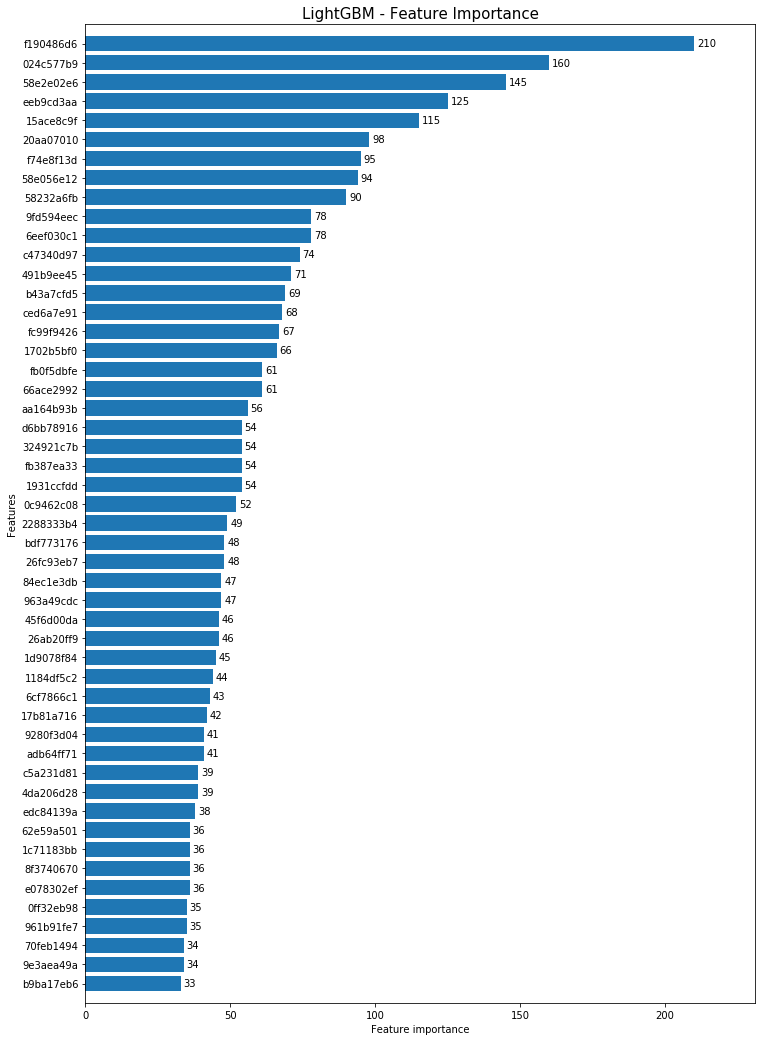

In [20]:
# Important features
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [21]:
answer3=pd.DataFrame()
answer3['ID']=test['ID']
answer3['target']=pred_test_full
answer3.to_csv("Submission3.csv",index=False)

Submission 3 provides the best result untill now.
On test data Model 3 gets 1.46 RMSLE

Next steps,
identifying important features and tuning lightGBM parameters.